In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import igraph as ig
import osmnx as ox

from pyrosm import get_data, OSM

In [30]:
import cenpy

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census ACS 2018 WMS

In [21]:
download = get_data("Northern California")
osm = OSM(download)

Downloaded Protobuf data 'norcal-latest.osm.pbf' (469.53 MB) to:
'/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/pyrosm/norcal-latest.osm.pbf'


In [23]:
drive_net = osm.get_network(network_type="driving")

In [25]:
metros = pd.read_csv("../data/metrolist_one.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

bay = metros[(metros.metro_name.str.contains('San Jose')) | (metros.metro_name.str.contains('San Francisco'))]
bay = bay[bay.county_name!="San Benito, CA"]

bay.head()

,metro_fips,metro_name,county_fips,county_name
963,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6001,"Alameda, CA"
964,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6013,"Contra Costa, CA"
965,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6041,"Marin, CA"
966,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6075,"San Francisco, CA"
967,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6081,"San Mateo, CA"


In [26]:
water = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    year = 2018
    
    sfips = fips[:2]
    cfips = fips[2:]
    
    url = f"https://www2.census.gov/geo/tiger/TIGER{year}/AREAWATER/tl_{year}_{sfips}{cfips}_areawater.zip"
    
    water.append(gpd.read_file(url))

water = gpd.GeoDataFrame(pd.concat(water, ignore_index=True))

In [28]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

In [31]:
nodes = list()
shape = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When maki

In [32]:
water = water.to_crs(3857)

water_dissolved = water.dissolve()
shape_dissolved = shape.dissolve()
background = shape_dissolved['geometry'].difference(water_dissolved['geometry'])

In [36]:
intersection = gpd.overlay(drive_net.to_crs(3857), shape_dissolved, how='intersection')

In [37]:
print(drive_net.shape)
print(intersection.shape)

(1134652, 41)
(381540, 41)


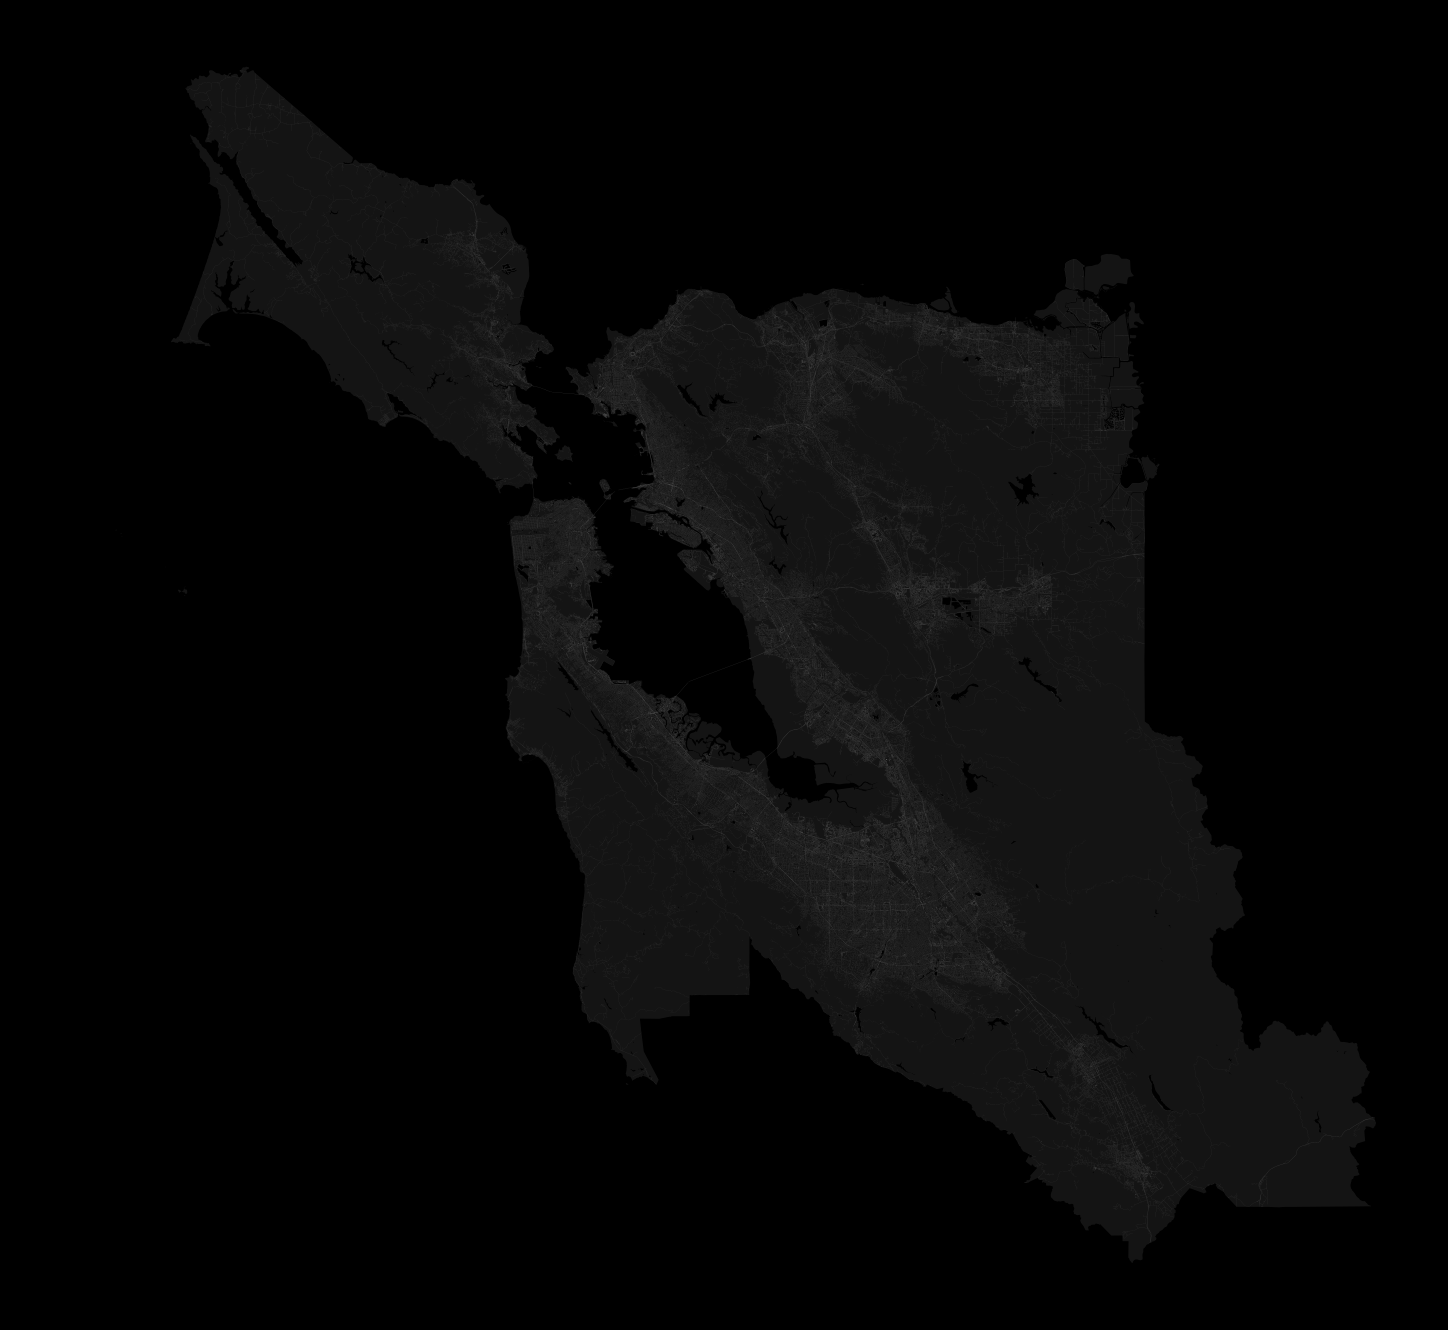

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

background.plot(color='dimgray', ax=ax, linewidth=0.5, alpha=0.2)
intersection.plot(color='white', ax=ax, linewidth=0.05, alpha=0.5)

ax.set_axis_off()

fig.savefig('bay_area.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')